# Week 7 lab - de novo assembly with De Bruijn graphs

For this week's lab you'll be writing programs to count k-mers and to find the edges of a de Bruijn graph.

As a reminder, we have a relevant tutorial document intended for those new to programming or learning Python: [kmer-counting tutorial](kmer_counting.ipynb). The first couple of challenges below are covered (more gently) in this tutorial. By now you have probably already learned the programming concepts in the tutorial, but you might still find it worth looking at the _Dictionaries: algorithmic considerations_ section. 

## KMER SIZE
Kmer size has a large impact on overall assembly quality.  <br>
The effect of this can be seen here: 
https://github.com/rrwick/Bandage/wiki/Effect-of-kmer-size
<br>
Today we will just work with small strings and small k, but keep this in mind for the future. 

## Data 

We'll define some toy "reads" from English strings, which you can use to see your functions in action.

In [1]:
yoda_reads = '''
ters_no
ers_not
matners
size_ma
tters_
atters_n
size_m
e_matter'''.strip().split("\n")
yoda_reads

['ters_no',
 'ers_not',
 'matners',
 'size_ma',
 'tters_',
 'atters_n',
 'size_m',
 'e_matter']

In [4]:
caesar_reads = '''
_your_e
l,nd_me
nd_me_y
d_me_y
omans,_
s,_coun
me_you
eids,_
mans,_c
our_ea
'''.strip().split("\n")
caesar_reads

['_your_e',
 'l,nd_me',
 'nd_me_y',
 'd_me_y',
 'omans,_',
 's,_coun',
 'me_you',
 'eids,_',
 'mans,_c',
 'our_ea']

In [5]:
# a version with no read errors
caesar_reads_perfect = '''
me_your_e
ymen,_len
_your_e
ds,_Roma
nds,_Roma
trymen,_
lend_me_
omans,_co
n,_lend_
riends,_R
ntrymen
,_country
e_your_ears
untryme
riends,_
'''.strip().split("\n")
caesar_reads_perfect

['me_your_e',
 'ymen,_len',
 '_your_e',
 'ds,_Roma',
 'nds,_Roma',
 'trymen,_',
 'lend_me_',
 'omans,_co',
 'n,_lend_',
 'riends,_R',
 'ntrymen',
 ',_country',
 'e_your_ears',
 'untryme',
 'riends,_']

And some error-free "reads" from a very small tRNA gene:

In [6]:
mt_te_reads = '''TGTAGTTGAAATACAACGAT
GGTCGTGGTTGTAGTCCGTGC
TGGTCGTGGTTGTAGTCCG
TATCATTGGTCGTGGTTGTAG
TTGTAGTTGAAATACAACGAT
ATCATTGGTCGTGGTTGTAG
ATGGTTTTTCATATCATTGG
GGTTTTTCATATCATTGGTCGT
GGTCGTGGTTGTAGTCCGT
TCATTGGTCGTGGTTGTAGTCC
GGTCGTGGTTGTAGTCCGTGCG
GATGGTTTTTCATATCATT
TGGTCGTGGTTGTAGTCC
AACGATGGTTTTTCATATCA
GGTTTTTCATATCATTGGTCG
GTTTTTCATATCATTGGTCGTG
ATTGGTCGTGGTTGTAGTCCGT
AACGATGGTTTTTCATAT
GTTTTTCATATCATTGGT
AACGATGGTTTTTCATAT'''.strip().split()
mt_te_reads

['TGTAGTTGAAATACAACGAT',
 'GGTCGTGGTTGTAGTCCGTGC',
 'TGGTCGTGGTTGTAGTCCG',
 'TATCATTGGTCGTGGTTGTAG',
 'TTGTAGTTGAAATACAACGAT',
 'ATCATTGGTCGTGGTTGTAG',
 'ATGGTTTTTCATATCATTGG',
 'GGTTTTTCATATCATTGGTCGT',
 'GGTCGTGGTTGTAGTCCGT',
 'TCATTGGTCGTGGTTGTAGTCC',
 'GGTCGTGGTTGTAGTCCGTGCG',
 'GATGGTTTTTCATATCATT',
 'TGGTCGTGGTTGTAGTCC',
 'AACGATGGTTTTTCATATCA',
 'GGTTTTTCATATCATTGGTCG',
 'GTTTTTCATATCATTGGTCGTG',
 'ATTGGTCGTGGTTGTAGTCCGT',
 'AACGATGGTTTTTCATAT',
 'GTTTTTCATATCATTGGT',
 'AACGATGGTTTTTCATAT']

## Counting k-mers 

**Exercise 1:**

Complete the function below to return all the k-mers from a given string. 

In [13]:
def get_string_kmers(read, k):
    '''
    Return a set of all k-mers of length k from string read.
    '''
    kmers = set()
    for i in range(len(read)-k+1):
        kmers.add(read[i:i+k])
    return kmers
    

In [14]:
# Should return {'_yo', 'our', 'r_e', 'ur_', 'you'}
get_string_kmers(caesar_reads[0], 3)

{'_yo', 'our', 'r_e', 'ur_', 'you'}

**Exercise 2:**

Write a function which applies `get_string_kmers()` to a list of strings and returns all kmers.

In [15]:
def get_kmers(reads, k):
    '''
    Given a list of strings representing reads, and a value k, 
    return a set of all k-mers of length k.
    '''
    kmers = set()
    for current_read in reads:
        current_kmers = get_string_kmers(current_read, k)
        kmers = kmers.union(current_kmers)
    
    return kmers

In [16]:
# Should return {'tters_','ize_ma','atners','ers_no','matner','rs_not','size_m',
#                '_matte','e_matt','atters','ters_n','matter'}
# (i.e. 12 unique kmers)
get_kmers(yoda_reads, 6)

{'_matte',
 'atners',
 'atters',
 'e_matt',
 'ers_no',
 'ize_ma',
 'matner',
 'matter',
 'rs_not',
 'size_m',
 'ters_n',
 'tters_'}

## Building a graph with networkx

We could represent a graph using Python data structures. For instance, here is one way to represent a graph where nodes B and C are linked from A:
    
    B <- A -> C


In [17]:
nodes = ['A','B','C']
edges = [('A','B'), ('A','C')]

Notice that a tree is a kind of graph, and we have already built trees using data structures in past labs.

This time we'll use a library `networkx` intended specifically for graph manipulation.

In [18]:
import matplotlib.pylab as plt
import networkx as nx

Here's how to build that same graph in networkx. Note that we use `DiGraph` instead of `Graph`, which gives a directed graph.

In [19]:
g = nx.DiGraph()
g.add_edge('A','B')
g.add_edge('A','C')

We could have explicitly added nodes with code like `g.add_node('A')`, but since every node is connected to at least one edge in this case, networkx automatically adds the nodes for us when the edges are added. 

Remember you can look at networkx method documentation with `?` or `help()`. Have a look at the documentation for the `add_edge` method.

In [20]:
g.nodes()

NodeView(('A', 'B', 'C'))

In [21]:
g.edges()

OutEdgeView([('A', 'B'), ('A', 'C')])

Here's a way to draw the graph with a spring layout, where networkx will try to place nodes so they are not too close together. This is a simple layout algorithm - it's easy to see the result for this tiny graph, but may be difficult see for graphs of any size. The layout is somewhat random and for larger graphs, will be different every time you draw it.

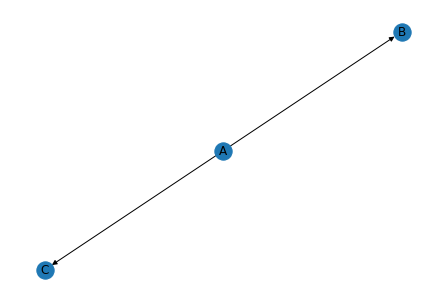

In [22]:
nx.draw_spring(g, with_labels=True)

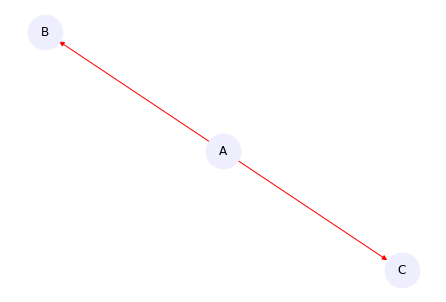

In [23]:
nx.draw_spring(g, with_labels=True, node_size=1200, node_color='#eeeeff', edge_color='red')

**Exercise 3:**

Write functions `get_suffix()` and `get_prefix()` which just return the `k-1`-length strings which are, respectively the suffix and prefix of the supplied k-mer.

In [24]:
# Write both functions here
def get_suffix(reads):
    return reads[1:]

def get_prefix(reads):
    return reads[:-1]


In [25]:
# Should return 'GGTA'
get_suffix('AGGTA')

'GGTA'

In [26]:
# Should return 'AGGT'
get_prefix('AGGTA')

'AGGT'

**Exercise 4:**

Given a set of reads and a value k, build a directed graph, using networkx, where nodes are the prefixes/suffixes of kmers and an edge exists for every kmer.

In [31]:
def build_graph(reads, k):
    '''
    Given a set of reads and a value k, return the networkx de Bruijn graph object.
    '''
    kmers = get_kmers(reads, k)
    graph = nx.DiGraph()
    # Complete this function
    for kmer in kmers:
        prefix_node = get_prefix(kmer)
        suffix_node = get_suffix(kmer)
        graph.add_edge(prefix_node, suffix_node)       
    return graph

In [32]:
yoda_graph = build_graph(yoda_reads, 4)

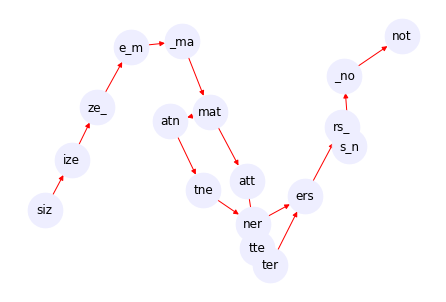

In [33]:
nx.draw_spring(yoda_graph, with_labels=True, node_size=1200, node_color='#eeeeff', edge_color='red')

**Challenge:** If you want a challenge, you can try to extract contigs from your graph as described in lectures. To extract a contig, we need to find an unbalanced node, then walk along the directed graph only so long as our path is unambiguous.

You can find the in-degree and out-degree of nodes (number of edges leading in and out), and the edges themselves, with networkx methods like so:

In [34]:
g = nx.DiGraph()
g.add_edge('A','B')
g.add_edge('A','C')

In [35]:
g.in_degree('A')

0

In [36]:
g.out_degree('A')

2

In [37]:
g.out_edges('A')

OutEdgeDataView([('A', 'B'), ('A', 'C')])